In [22]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf
using Plots

const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007f867c9e1400, false, 0)

In [ ]:
Pb1_arcs.csv: A 90×5 matrix reporting, for each arc (column 1), the starting and ending
nodes (columns 2 and 3), the capacity (column 4) and the construction cost (column 5).
– Pb2_transport.csv: A 90×3 matrix reporting the unit transportation cost on each arc (rows)
for each customer (columns).
– Pb2_demand.csv: A 3×2 matrix reporting the demand from each customer (rows) in each
scenario (columns).
– Pb2_customer_OD.csv: A 3×2 matrix reporting, for each customer (rows), the origin (column
1) and the destination (column 2).

In [23]:
arcs = CSV.read("Pb1_arcs.csv", DataFrame)
transport = CSV.read("Pb1_transport.csv", DataFrame)
demand = CSV.read("Pb1_demand.csv", DataFrame)
customers = CSV.read("Pb1_customer_OD.csv", DataFrame)
arcs_ = convert.(Int64,arcs[!,1:2])

,x1,x2
,Int64,Int64
1,1,9
2,4,2
3,8,2


In [17]:
customers

,x1,x2
,Int64,Int64
1,1,9
2,4,2
3,8,2


## 1. Problem setup

We want to solve the following stochastic facility location problem:

$$\begin{align}
\min\quad & \sum_{i=1}^Nc_ix_i+\sum_{s=1}^Sp_s\left(\sum_{i=1}^N\sum_{j=1}^Mt_{ij}y_{ij}^s + \sum_{j=1}^Mq_jz_{j}^s\right)\\
\text{s.t.}\quad & \sum_{i=1}^Ny_{ij}^s+z_j^s\ge d_j^s & \forall j\in [M], s\in [S]\\
& \sum_{j=1}^My_{ij}^s \le C_ix_i&\forall i\in[N], s\in[S]\\
& \mathbf{y,z}\ge 0, \mathbf{x}\in\{0,1\}^N
\end{align}$$

Dual subproblem $s$:
$$\begin{align}
\max\quad &  \sum_{j=1}^M \mu_j d_j^s - \sum_{i=1}^N\lambda_iC_ix_i\\
\text{s.t.}\quad & \mu_j -\lambda_i \le t_{ij} & \forall i\in[N], j\in[M]\\
& \mu_j \le q_j &\forall j\in [M]\\
& \mathbf{\mu, \lambda}\ge 0
\end{align}$$

- If the dual subproblem is unbounded, we obtain an extreme ray $(\mu^*, \lambda^*)$ and add a feasibility cut:
$$\sum_{j=1}^M\mu^*_j d_j^s - \sum_{i=1}^N \lambda^*_i C_i x_i \le 0$$

- If the dual subproblem solves to optimality, we obtain an extreme point $(\mu^*, \lambda^*)$ and add an optimality cut:
$$θ_s \ge \sum_{j=1}^M\mu^*_j d_j^s - \sum_{i=1}^N\lambda^*_i C_i x_i$$

\begin{equation}
    \label{eq:subproblem-stochastic-dual}
    \begin{array}{ll}
        \max & \sum_{k \in \mathcal{K}} d_k^s ({\pi_{O_k, k}^s - \pi_{D_k,k}^s}) + \sum_{(i, j) \in \mathcal{A}} u_{i j} x_{i j} \mu_{ i j}^s \\
        \text { s.t. } & \pi_{i, k}^s - \pi_{j, k}^s + \mu_{i j}^s \leq f_{i j k}, \forall (i, j) \in \mathcal{A}, k \in \mathcal{K} \\
        & \pi_{i k}^s \in \mathbb{R}, \forall i \in \mathcal{N}, k \in \mathcal{K} \\
        & \mu_{i j}^s \leq 0,  \forall(i, j) \in \mathcal{A} \\
    \end{array}
\end{equation}

In [98]:
TIME_LIMIT = 90;
OPTIMALITY_GAP = 0.001;

"Solve problem using multi-cut Benders decomposition"
function solve_benders_multi(verbose::Bool=true)
    # define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV));
    set_optimizer_attributes(MP, "TimeLimit" => 60, "MIPGap" => 1e-4, "OutputFlag" => 0, "DualReductions" => 0)
    A = size(arcs, 1); K = size(customers, 1); S = size(demand, 2)
    @variable(MP, x[1:A], Bin)
    @variable(MP, θ[1:S] >= 0)
    @objective(MP, Min, sum(arcs[i,5] * x[i] for i=1:A) + sum(1/S * θ[s] for s in 1:S))
#10
    lower_bound_all = []; upper_bound_all = []
    MP_time = []; SP_max_time = []; SP_time = []
    num_opt = 0; num_feas = 0
    while true
        # solve master problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])
        # solve S subproblems
        obj_SP = zeros(S) #20
        SP_time_all = zeros(S)
        for s = 1:S
            
            SP_dual = Model(JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), 
                "OutputFlag" => 0, "DualReductions" => 0, "TimeLimit" => 60))
            
            @variable(SP_dual, λ[1:A,1:K]);
            @variable(SP_dual, μ[1:A] <= 0);
            
            @objective(SP_dual, Max,
                       sum((λ[customers[k,1],k]-λ[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ[i] * arcs[i,4] * x_MP[i] for i in 1:A))
            
            @constraint(SP_dual, [i in 1:A, k in 1:K], 
                λ[arcs_[i,1],k] - λ[arcs_[i,2],k] + μ[i] <= transport[i,k])

            SP_time_all[s] = @elapsed optimize!(SP_dual)
            #obj_SP_dual = objective_value(SP_dual)
            λ_val = value.(SP_dual[:λ])
            μ_val = value.(SP_dual[:μ])            
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE # feasibility cut
                @constraint(MP, sum((λ_val[customers[k,1],k]-λ_val[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ_val[i] * arcs[i,4] * x[i] for i in 1:A) <= 0) 
                obj_SP[s] = 3000
                num_feas += 1
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                @constraint(MP, θ[s] >= sum((λ_val[customers[k,1],k]-λ_val[customers[k,2],k]) * demand[k,s] for k in 1:K) +
                       sum(μ_val[i] * arcs[i,4] * x[i] for i in 1:A))
                obj_SP[s] = objective_value(SP_dual)
                num_opt += 1
            end
        end
        push!(SP_max_time, maximum(SP_time_all))
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = sum(arcs[i,5] * x_MP[i] for i=1:A) + sum(1/S * obj_SP[s] for s in 1:S)
        push!(upper_bound_all, upper_bound_new)
        verbose && @printf("UB: %.2f - LB: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        if sum(MP_time) + sum(SP_time) >= TIME_LIMIT ||
            (upper_bound_new-lower_bound_new)/lower_bound_new < OPTIMALITY_GAP
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time, SP_max_time, num_feas, num_opt
end

solve_benders_multi

In [99]:
upper_bound_all, lower_bound_all, MP_time, SP_time, SP_max_time, num_feas, num_opt = solve_benders_multi()

UB: 3000.00 - LB: 0.00
UB: 3012.95 - LB: 12.95
UB: 3024.45 - LB: 24.45
UB: 3047.98 - LB: 47.98
UB: 3074.85 - LB: 74.85
UB: 3089.12 - LB: 89.12
UB: 3100.12 - LB: 100.12
UB: 3113.96 - LB: 113.96
UB: 10803.37 - LB: 126.79
UB: 10803.37 - LB: 10803.37


(Any[3000.0, 3012.9542231933287, 3024.4472945850457, 3047.981907230408, 3074.8503969489125, 3089.121129900808, 3100.124060075477, 3113.958045257988, 10803.374926743361, 10803.374926743361], Any[0.0, 12.954223193328552, 24.44729458504561, 47.98190723040824, 74.85039694891242, 89.12112990080766, 100.12406007547688, 113.95804525798818, 126.7892323405191, 10803.374926743358], Any[0.000703592, 0.000469047, 0.000423857, 0.000418025, 0.000374965, 0.000391986, 0.000361605, 0.000486252, 0.000435249, 0.000478057], Any[0.002499309, 0.002984003, 0.002881994, 0.002748373, 0.0028821489999999996, 0.002605596, 0.025801527, 0.003019862, 0.0028587029999999998, 0.002883458], Any[0.001320414, 0.00155138, 0.001450267, 0.001434301, 0.001502708, 0.001312837, 0.024221776, 0.001521269, 0.001433395, 0.001443107], 16, 4)

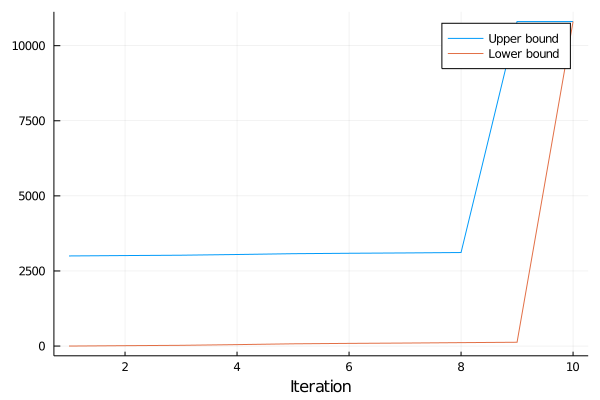

In [100]:
plot([upper_bound_all lower_bound_all], label=["Upper bound" "Lower bound"], xlabel="Iteration")

In [101]:
@show length(upper_bound_all)
@show num_opt 
@show num_feas

length(upper_bound_all) = 10
num_opt = 4
num_feas = 16


16